<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/CB_Step_4_Machine_Learning_Models_(With_Feature_Engineering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Enhanced Feature Engineering
def create_advanced_features(df, target='calls'):
    df = df.copy()

    # 1. Multiple lag features (capture different periodicities)
    for lag in [1, 2, 3, 7, 14, 21, 28]:  # Daily, weekly, bi-weekly, monthly patterns
        df[f'Lag{lag}'] = df[target].shift(lag)

    # 2. Rolling statistics with multiple windows
    for window in [3, 7, 14, 21, 28]:
        df[f'Rolling_Mean_{window}'] = df[target].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'Rolling_Std_{window}'] = df[target].shift(1).rolling(window=window, min_periods=1).std()
        df[f'Rolling_Min_{window}'] = df[target].shift(1).rolling(window=window, min_periods=1).min()
        df[f'Rolling_Max_{window}'] = df[target].shift(1).rolling(window=window, min_periods=1).max()

    # 3. Exponentially weighted moving averages (more weight to recent observations)
    for span in [7, 14, 21]:
        df[f'EWMA_{span}'] = df[target].shift(1).ewm(span=span, adjust=False).mean()

    # 4. Lag ratios (capture growth patterns)
    df['Lag1_to_Lag7_ratio'] = df['Lag1'] / (df['Lag7'] + 1)  # Avoid division by zero
    df['Lag7_to_Lag14_ratio'] = df['Lag7'] / (df['Lag14'] + 1)

    # 5. Time-based features
    df['DayOfMonth'] = df.index.day
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['DayOfYear'] = df.index.dayofyear

    # 6. Cyclical encoding for temporal features
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    df['DayOfMonth_sin'] = np.sin(2 * np.pi * df['DayOfMonth'] / 31)
    df['DayOfMonth_cos'] = np.cos(2 * np.pi * df['DayOfMonth'] / 31)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    # 7. Interaction features
    df['Lag1_x_DayOfWeek'] = df['Lag1'] * df.index.dayofweek
    df['Lag7_x_Rolling_Mean_7'] = df['Lag7'] * df['Rolling_Mean_7']

    # 8. Trend features
    df['Days_Since_Start'] = (df.index - df.index[0]).days
    df['Trend_Linear'] = np.arange(len(df))
    df['Trend_Squared'] = df['Trend_Linear'] ** 2

    # 9. Weekend indicator
    df['IsWeekend'] = (df.index.dayofweek >= 5).astype(int)

    # 10. Previous week same day
    df['Lag_SameDay_LastWeek'] = df[target].shift(7)
    df['Lag_SameDay_2WeeksAgo'] = df[target].shift(14)

    return df

# Hyperparameter tuning for best models
def tune_models(X_train, y_train):
    tscv = TimeSeriesSplit(n_splits=3)  # Fewer splits for faster tuning

    # XGBoost parameters
    xgb_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # RandomForest parameters
    rf_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # ElasticNet parameters
    en_params = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }

    models = {
        'XGBoost': (XGBRegressor(random_state=42), xgb_params),
        'RandomForest': (RandomForestRegressor(random_state=42), rf_params),
        'ElasticNet': (ElasticNet(random_state=42, max_iter=2000), en_params)
    }

    best_models = {}
    for name, (model, params) in models.items():
        print(f"Tuning {name}...")
        grid = GridSearchCV(model, params, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_models[name] = grid.best_estimator_
        print(f"Best params for {name}: {grid.best_params_}")

    return best_models

# Feature selection using importance
def select_important_features(X, y, model, top_n=30):
    model.fit(X, y)

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        return X.columns.tolist()

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)

    return feature_importance.head(top_n)['feature'].tolist()

# Main optimization code
df = pd.read_csv('enhanced_eda_data.csv', index_col='Date', parse_dates=True)

# Apply advanced feature engineering
df_enhanced = create_advanced_features(df)

# Handle missing values from lagged features
df_enhanced = df_enhanced.dropna()

# Separate features and target
target = 'calls'
feature_cols = [col for col in df_enhanced.columns if col != target and df_enhanced[col].dtype in ['float64', 'int64', 'uint8']]
X = df_enhanced[feature_cols]
y = df_enhanced[target]

# Scale features (important for regularized models)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Feature selection
print("Selecting important features...")
top_features = select_important_features(X_scaled, y, RandomForestRegressor(n_estimators=100, random_state=42))
X_selected = X_scaled[top_features]

# Hyperparameter tuning
print("\nTuning models...")
best_models = tune_models(X_selected, y)

# Evaluate with proper cross-validation
tscv = TimeSeriesSplit(n_splits=5)
results = {}

for name, model in best_models.items():
    scores = []
    for train_idx, test_idx in tscv.split(X_selected):
        X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mae = mean_absolute_error(y_test, preds)
        scores.append(mae)

    results[name] = np.mean(scores)
    print(f"{name}: MAE = {np.mean(scores):.2f}")

Selecting important features...

Tuning models...
Tuning XGBoost...
Best params for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Tuning RandomForest...
Best params for RandomForest: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Tuning ElasticNet...
Best params for ElasticNet: {'alpha': 1.0, 'l1_ratio': 0.7}
XGBoost: MAE = 888.53
RandomForest: MAE = 870.01
ElasticNet: MAE = 667.78


In [ ]:
from sklearn.ensemble import StackingRegressor

base_models = [
    ('xgb', best_models['XGBoost']),
    ('rf', best_models['RandomForest']),
    ('en', best_models['ElasticNet'])
]

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(alpha=1.0),
    cv=5
)

In [ ]:
# Log transform for skewed data
y_log = np.log1p(y)
# Train on transformed target, then inverse transform predictions

In [ ]:
# ============================================================
# MODEL EVALUATION AND LEADERBOARD
# ============================================================

import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

# Helper function to calculate all metrics
def calculate_metrics(y_true, y_pred, naive_seasonal_mae=858):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mase = mae / naive_seasonal_mae
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'MASE': mase}

# Setup TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Dictionary to store all metrics
all_metrics = {}

# Evaluate each model
for name, model in best_models.items():
    print(f"Running Cross-Validation for {name}...")

    # Lists to store metrics for each fold
    fold_maes, fold_rmses, fold_mapes, fold_mases = [], [], [], []

    for train_idx, test_idx in tscv.split(X_selected):
        X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        metrics = calculate_metrics(y_test, preds)
        fold_maes.append(metrics['MAE'])
        fold_rmses.append(metrics['RMSE'])
        fold_mapes.append(metrics['MAPE'])
        fold_mases.append(metrics['MASE'])

    # Store the average of the metrics across all folds
    all_metrics[name] = {
        'MAE': np.mean(fold_maes),
        'RMSE': np.mean(fold_rmses),
        'MAPE': np.mean(fold_mapes),
        'MASE': np.mean(fold_mases)
    }

# Create and display the leaderboard
leaderboard = pd.DataFrame.from_dict(all_metrics, orient='index').sort_values('MAE')
champion_model_name = leaderboard.index[0]
champion_model_instance = best_models[champion_model_name]

print("\n" + "="*50 + "\nMACHINE LEARNING MODEL LEADERBOARD\n" + "="*50)
print(leaderboard)
print(f"\n🏆 Champion ML Model: {champion_model_name}")

# Save champion model for later use
champion_model = champion_model_instance

Running Cross-Validation for XGBoost...
Running Cross-Validation for RandomForest...
Running Cross-Validation for ElasticNet...

MACHINE LEARNING MODEL LEADERBOARD
                     MAE         RMSE       MAPE      MASE
ElasticNet    667.776507   946.876181   8.595421  0.778294
RandomForest  870.014935  1232.624488  10.563369  1.014003
XGBoost       888.533691  1233.447127  11.035045  1.035587

🏆 Champion ML Model: ElasticNet


COMPREHENSIVE ANALYSIS FOR CHAMPION MODEL: ElasticNet


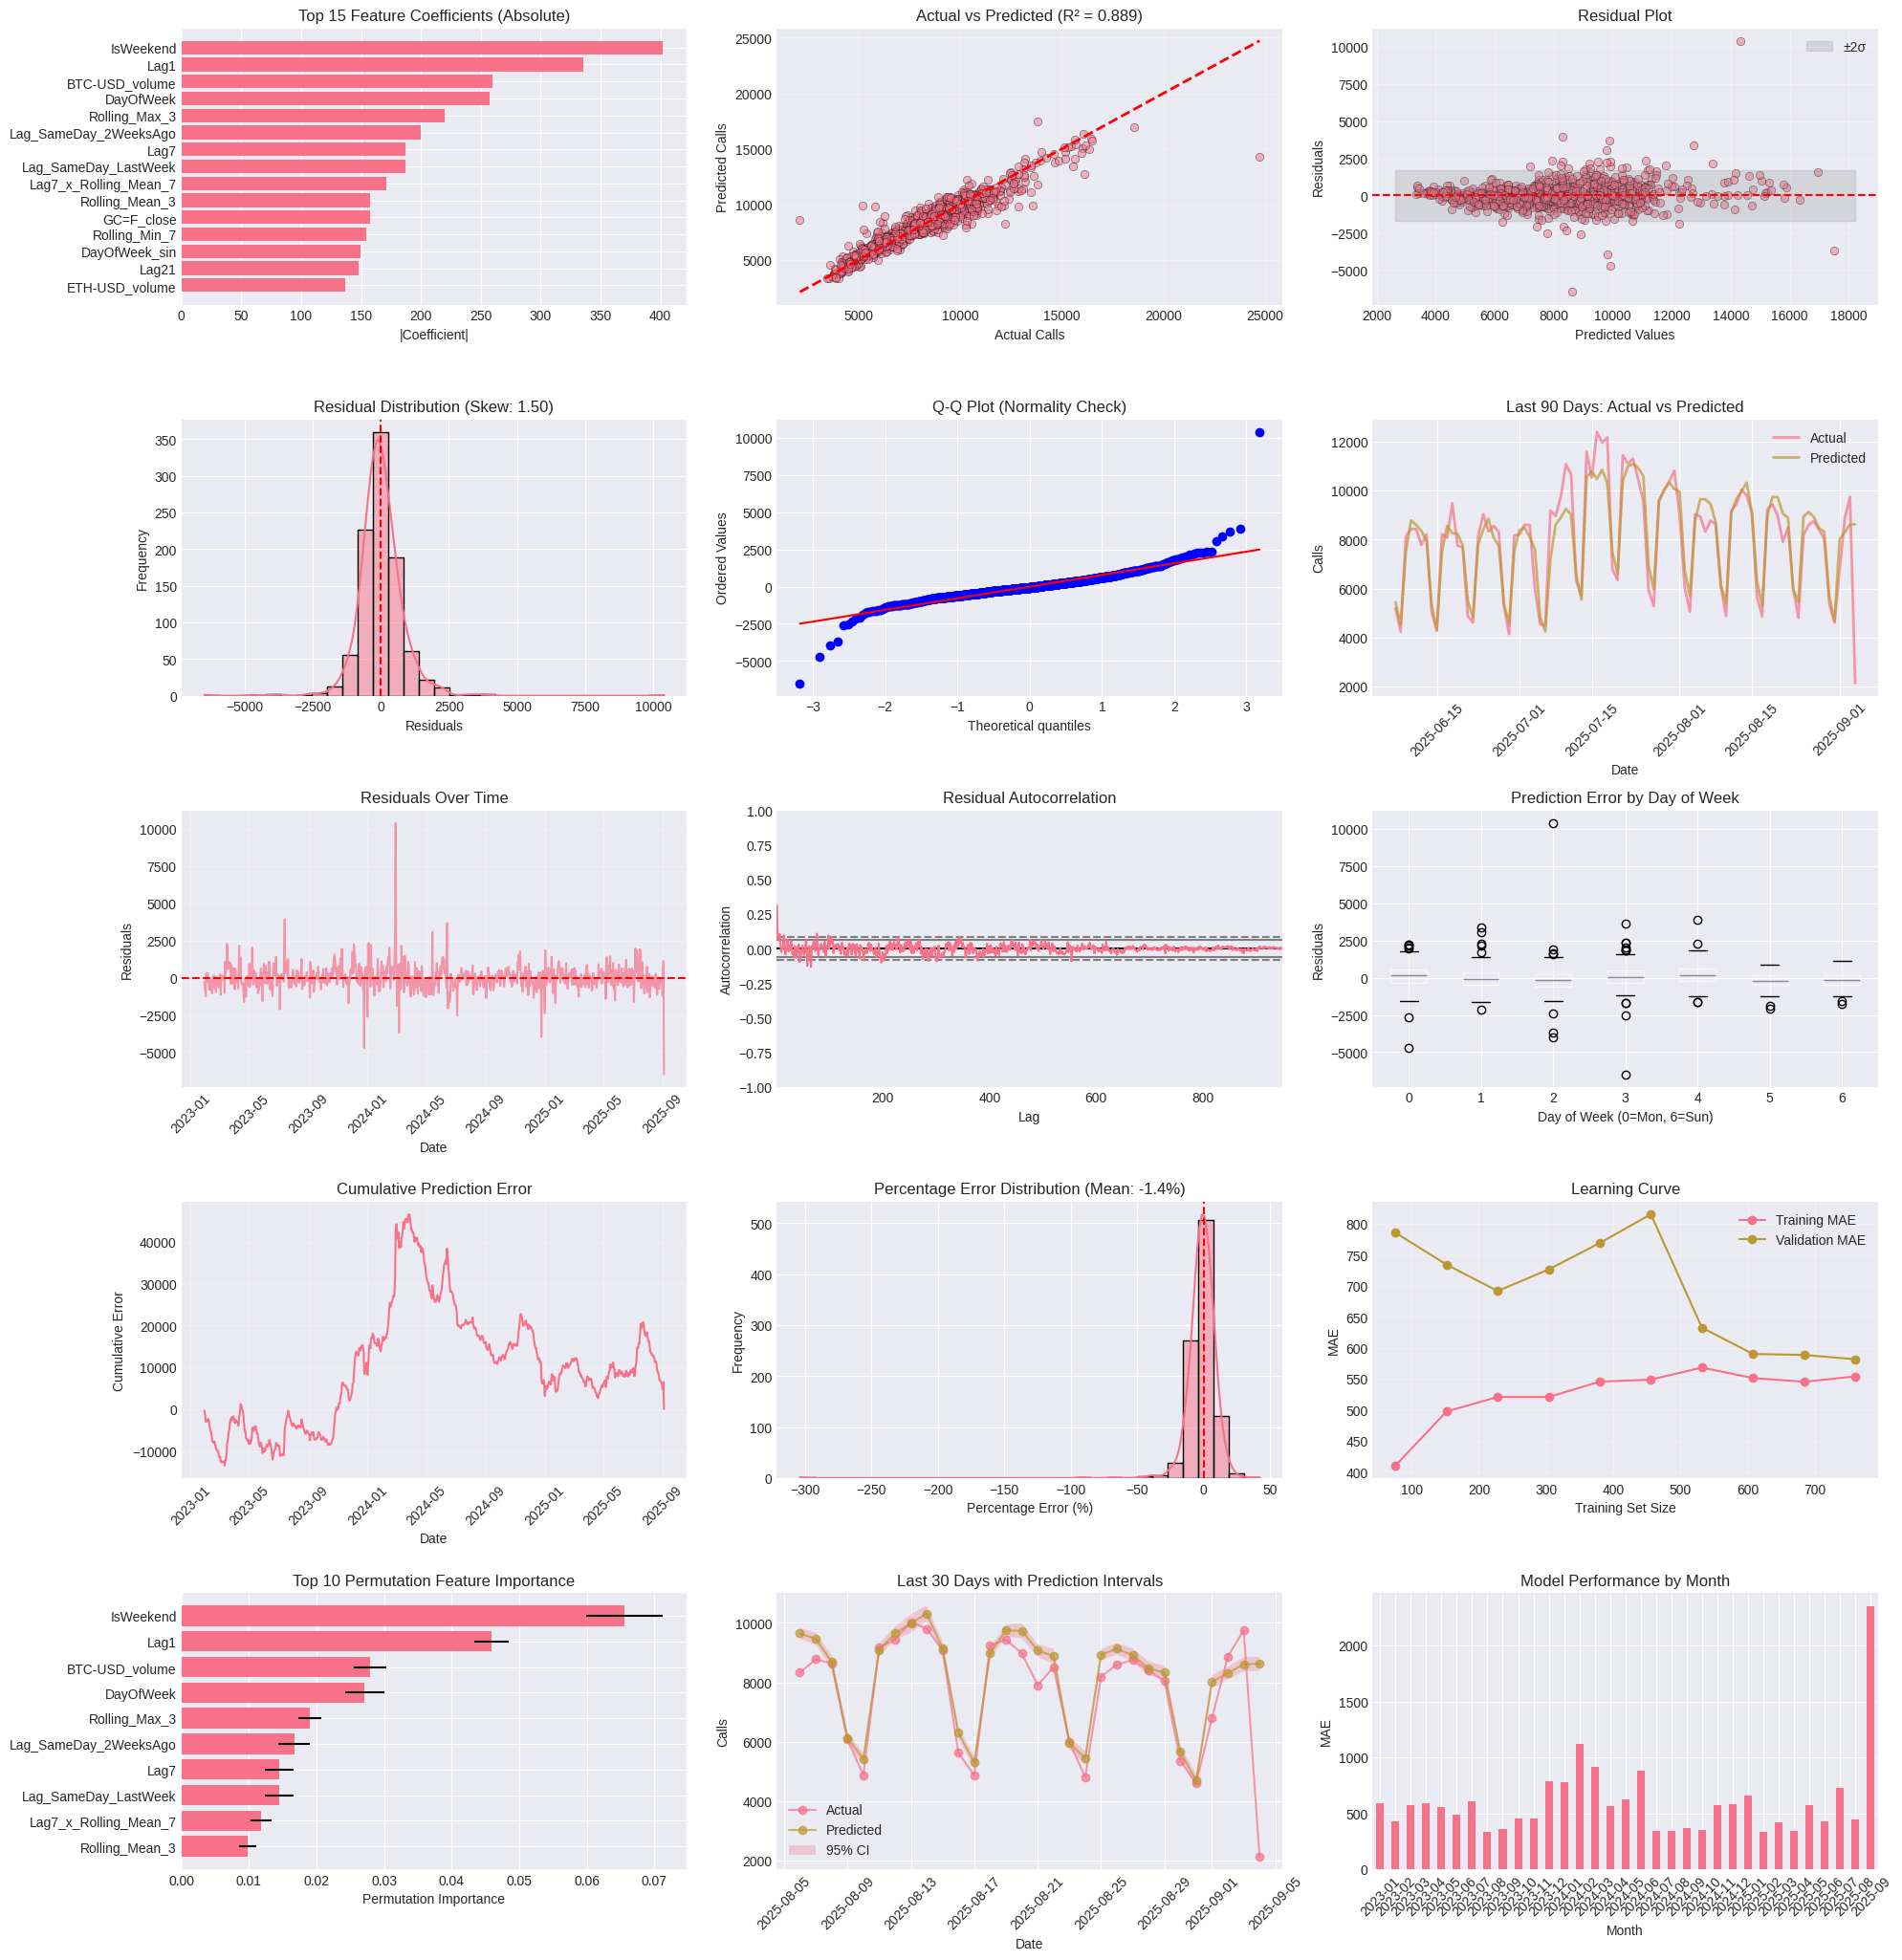


STATISTICAL SUMMARY

📊 OVERALL PERFORMANCE METRICS:
   MAE:  556.31
   RMSE: 856.07
   MAPE: 7.05%
   MASE: 0.648
   R²:   0.889

📈 RESIDUAL ANALYSIS:
   Mean Residual:     -0.00
   Std Residual:      856.07
   Skewness:          1.500
   Kurtosis:          28.257

   Shapiro-Wilk Test: p-value = 0.0000
   ✗ Residuals are NOT normally distributed

   Ljung-Box Test: p-value = 0.0000
   ✗ Residuals show autocorrelation

ANALYSIS COMPLETE


In [ ]:
# ============================================================
# CHAMPION MODEL ANALYSIS & VISUALIZATION SUITE
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with subplots
fig = plt.figure(figsize=(20, 24))

print("="*70)
print(f"COMPREHENSIVE ANALYSIS FOR CHAMPION MODEL: {champion_model_name}")
print("="*70)

# Retrain on full data for final analysis
champion_model.fit(X_selected, y)
predictions = champion_model.predict(X_selected)
residuals = y - predictions

# ============================================================
# 1. FEATURE IMPORTANCE
# ============================================================
ax1 = plt.subplot(6, 3, 1)
if hasattr(champion_model, 'feature_importances_'):
    importances = champion_model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': X_selected.columns,
        'importance': importances
    }).sort_values('importance', ascending=False).head(15)

    plt.barh(range(len(feature_importance)), feature_importance['importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Importance')
    plt.title('Top 15 Feature Importances')
    plt.gca().invert_yaxis()
elif hasattr(champion_model, 'coef_'):
    coef_importance = pd.DataFrame({
        'feature': X_selected.columns,
        'coefficient': np.abs(champion_model.coef_)
    }).sort_values('coefficient', ascending=False).head(15)

    plt.barh(range(len(coef_importance)), coef_importance['coefficient'])
    plt.yticks(range(len(coef_importance)), coef_importance['feature'])
    plt.xlabel('|Coefficient|')
    plt.title('Top 15 Feature Coefficients (Absolute)')
    plt.gca().invert_yaxis()

# ============================================================
# 2. ACTUAL VS PREDICTED
# ============================================================
ax2 = plt.subplot(6, 3, 2)
plt.scatter(y, predictions, alpha=0.5, edgecolors='k', linewidth=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Calls')
plt.ylabel('Predicted Calls')
plt.title(f'Actual vs Predicted (R² = {np.corrcoef(y, predictions)[0,1]**2:.3f})')
plt.grid(True, alpha=0.3)

# ============================================================
# 3. RESIDUALS VS PREDICTED
# ============================================================
ax3 = plt.subplot(6, 3, 3)
plt.scatter(predictions, residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

# Add confidence bands
residual_std = np.std(residuals)
plt.fill_between(plt.xlim(), -2*residual_std, 2*residual_std, alpha=0.2, color='gray', label='±2σ')
plt.legend()

# ============================================================
# 4. RESIDUAL DISTRIBUTION
# ============================================================
ax4 = plt.subplot(6, 3, 4)
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title(f'Residual Distribution (Skew: {stats.skew(residuals):.2f})')

# ============================================================
# 5. Q-Q PLOT
# ============================================================
ax5 = plt.subplot(6, 3, 5)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)')

# ============================================================
# 6. TIME SERIES - ACTUAL VS PREDICTED
# ============================================================
ax6 = plt.subplot(6, 3, 6)
last_n = min(90, len(y))  # Last 90 days or available data
plt.plot(y.index[-last_n:], y.values[-last_n:], label='Actual', linewidth=2, alpha=0.7)
plt.plot(y.index[-last_n:], predictions[-last_n:], label='Predicted', linewidth=2, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Calls')
plt.title('Last 90 Days: Actual vs Predicted')
plt.legend()
plt.xticks(rotation=45)

# ============================================================
# 7. RESIDUALS OVER TIME
# ============================================================
ax7 = plt.subplot(6, 3, 7)
plt.plot(y.index, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# ============================================================
# 8. AUTOCORRELATION OF RESIDUALS
# ============================================================
ax8 = plt.subplot(6, 3, 8)
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(pd.Series(residuals))
plt.title('Residual Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# ============================================================
# 9. ERROR BY DAY OF WEEK
# ============================================================
ax9 = plt.subplot(6, 3, 9)
error_by_dow = pd.DataFrame({
    'residual': residuals,
    'dow': y.index.dayofweek
})
error_by_dow.boxplot(by='dow', ax=ax9)
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('Residuals')
plt.title('Prediction Error by Day of Week')
plt.suptitle('')  # Remove automatic title

# ============================================================
# 10. CUMULATIVE ERROR
# ============================================================
ax10 = plt.subplot(6, 3, 10)
cumulative_error = np.cumsum(residuals)
plt.plot(y.index, cumulative_error)
plt.xlabel('Date')
plt.ylabel('Cumulative Error')
plt.title('Cumulative Prediction Error')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# ============================================================
# 11. PERCENTAGE ERROR DISTRIBUTION
# ============================================================
ax11 = plt.subplot(6, 3, 11)
percentage_errors = (residuals / y) * 100
percentage_errors = percentage_errors[np.isfinite(percentage_errors)]  # Remove inf values
sns.histplot(percentage_errors, kde=True, bins=30)
plt.xlabel('Percentage Error (%)')
plt.ylabel('Frequency')
plt.title(f'Percentage Error Distribution (Mean: {np.mean(percentage_errors):.1f}%)')
plt.axvline(x=0, color='r', linestyle='--')

# ============================================================
# 12. LEARNING CURVE
# ============================================================
ax12 = plt.subplot(6, 3, 12)
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    champion_model, X_selected, y, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_absolute_error'
)
plt.plot(train_sizes, -train_scores.mean(axis=1), 'o-', label='Training MAE')
plt.plot(train_sizes, -val_scores.mean(axis=1), 'o-', label='Validation MAE')
plt.xlabel('Training Set Size')
plt.ylabel('MAE')
plt.title('Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# ============================================================
# 13. PERMUTATION IMPORTANCE
# ============================================================
ax13 = plt.subplot(6, 3, 13)
perm_importance = permutation_importance(champion_model, X_selected, y, n_repeats=10, random_state=42)
perm_imp_df = pd.DataFrame({
    'feature': X_selected.columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False).head(10)

plt.barh(range(len(perm_imp_df)), perm_imp_df['importance'], xerr=perm_imp_df['std'])
plt.yticks(range(len(perm_imp_df)), perm_imp_df['feature'])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Permutation Feature Importance')
plt.gca().invert_yaxis()

# ============================================================
# 14. PREDICTION INTERVALS
# ============================================================
ax14 = plt.subplot(6, 3, 14)
# Bootstrap confidence intervals
n_bootstrap = 100
bootstrap_preds = []
for _ in range(n_bootstrap):
    indices = np.random.choice(len(X_selected), len(X_selected), replace=True)
    X_boot = X_selected.iloc[indices]
    y_boot = y.iloc[indices]
    model_boot = champion_model.__class__(**champion_model.get_params())
    model_boot.fit(X_boot, y_boot)
    bootstrap_preds.append(model_boot.predict(X_selected[-30:]))

bootstrap_preds = np.array(bootstrap_preds)
pred_mean = bootstrap_preds.mean(axis=0)
pred_std = bootstrap_preds.std(axis=0)

plt.plot(y.index[-30:], y.values[-30:], 'o-', label='Actual', alpha=0.7)
plt.plot(y.index[-30:], pred_mean, 'o-', label='Predicted', alpha=0.7)
plt.fill_between(y.index[-30:], pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.3, label='95% CI')
plt.xlabel('Date')
plt.ylabel('Calls')
plt.title('Last 30 Days with Prediction Intervals')
plt.legend()
plt.xticks(rotation=45)

# ============================================================
# 15. MONTHLY PERFORMANCE
# ============================================================
ax15 = plt.subplot(6, 3, 15)
monthly_perf = pd.DataFrame({
    'actual': y,
    'predicted': predictions,
    'month': y.index.to_period('M')
})
monthly_mae = monthly_perf.groupby('month').apply(lambda x: mean_absolute_error(x['actual'], x['predicted']))
monthly_mae.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('MAE')
plt.title('Model Performance by Month')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('champion_model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# STATISTICAL SUMMARY
# ============================================================
print("\n" + "="*70)
print("STATISTICAL SUMMARY")
print("="*70)

# Model Metrics
final_metrics = calculate_metrics(y, predictions)
print("\n📊 OVERALL PERFORMANCE METRICS:")
print(f"   MAE:  {final_metrics['MAE']:.2f}")
print(f"   RMSE: {final_metrics['RMSE']:.2f}")
print(f"   MAPE: {final_metrics['MAPE']:.2f}%")
print(f"   MASE: {final_metrics['MASE']:.3f}")
print(f"   R²:   {np.corrcoef(y, predictions)[0,1]**2:.3f}")

# Residual Statistics
print("\n📈 RESIDUAL ANALYSIS:")
print(f"   Mean Residual:     {np.mean(residuals):.2f}")
print(f"   Std Residual:      {np.std(residuals):.2f}")
print(f"   Skewness:          {stats.skew(residuals):.3f}")
print(f"   Kurtosis:          {stats.kurtosis(residuals):.3f}")

# Normality Tests
shapiro_stat, shapiro_p = stats.shapiro(residuals[:5000] if len(residuals) > 5000 else residuals)
print(f"\n   Shapiro-Wilk Test: p-value = {shapiro_p:.4f}")
print(f"   {'✓' if shapiro_p > 0.05 else '✗'} Residuals are {'normally' if shapiro_p > 0.05 else 'NOT normally'} distributed")

# Autocorrelation Test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(f"\n   Ljung-Box Test: p-value = {lb_test['lb_pvalue'].iloc[0]:.4f}")
print(f"   {'✓' if lb_test['lb_pvalue'].iloc[0] > 0.05 else '✗'} Residuals {'show NO' if lb_test['lb_pvalue'].iloc[0] > 0.05 else 'show'} autocorrelation")

# SHAP Analysis (for tree-based models only)
if champion_model_name in ['XGBoost', 'RandomForest']:
    try:
        import shap
        print("\n" + "="*70)
        print("SHAP ANALYSIS")
        print("="*70)

        # Create SHAP explainer
        explainer = shap.TreeExplainer(champion_model)
        shap_values = explainer.shap_values(X_selected)

        # SHAP Summary Plot
        fig2, axes = plt.subplots(1, 2, figsize=(16, 6))

        plt.sca(axes[0])
        shap.summary_plot(shap_values, X_selected, show=False, plot_size=(8, 6))

        plt.sca(axes[1])
        shap.summary_plot(shap_values, X_selected, plot_type="bar", show=False)

        plt.tight_layout()
        plt.savefig('shap_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

    except ImportError:
        print("\n⚠️  Install shap for SHAP analysis: pip install shap")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import numpy as np

def display_champion_report(y_true, y_pred, champion_name, model_object=None, X_features=None):
    """
    Displays a comprehensive set of visualizations and statistical metrics
    for a champion model directly in the notebook.
    """

    # Ensure inputs are pandas Series for easier handling
    y_true = pd.Series(y_true).squeeze()
    y_pred = pd.Series(y_pred, index=y_true.index).squeeze()
    residuals = y_true - y_pred

    print("=" * 70)
    print(f"🏆 CHAMPION MODEL REPORT: {champion_name}")
    print("=" * 70)

    # --- Plot 1: Actual vs. Predicted ---
    plt.figure(figsize=(15, 6))
    plt.plot(y_true.index, y_true, label='Actual Values', color='dodgerblue', alpha=0.8)
    plt.plot(y_pred.index, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title('Actual vs. Predicted Values', fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Calls')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    # --- Plot 2: Residuals Over Time ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(x=residuals.index, y=residuals, color='purple')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals Over Time', fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Error')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    # --- Plot 3 & 4: Residual Distribution and QQ Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.histplot(residuals, kde=True, ax=axes[0], color='green')
    axes[0].set_title('Residual Distribution')
    stats.probplot(residuals, dist="norm", plot=axes[1])
    axes[1].set_title('QQ Plot of Residuals')
    fig.suptitle('Residual Normality Check', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Plot 5 & 6: Autocorrelation (ACF) and Partial Autocorrelation (PACF) ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    plot_acf(residuals, ax=axes[0], lags=40)
    plot_pacf(residuals, ax=axes[1], lags=40)
    fig.suptitle('Autocorrelation of Residuals', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Statistical Summary ---
    print("\n" + "=" * 70)
    print("STATISTICAL SUMMARY")
    print("=" * 70 + "\n")

    # Performance Metrics
    mae = np.mean(np.abs(residuals))
    rmse = np.sqrt(np.mean(residuals**2))
    mape = np.mean(np.abs(residuals / y_true)) * 100
    mase_numerator = np.mean(np.abs(residuals))
    mase_denominator = np.mean(np.abs(np.diff(y_true)))
    mase = mase_numerator / mase_denominator
    r2 = 1 - (np.sum(residuals**2) / np.sum((y_true - y_true.mean())**2))

    print("📊 OVERALL PERFORMANCE METRICS:")
    print(f"   MAE:  {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   MASE: {mase:.3f}")
    print(f"   R²:   {r2:.3f}\n")

    # Residual Analysis
    shapiro_test = stats.shapiro(residuals)
    ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

    print("📈 RESIDUAL ANALYSIS:")
    print(f"   Mean Residual:     {residuals.mean():.2f}")
    print(f"   Std Residual:      {residuals.std():.2f}")
    print(f"   Skewness:          {residuals.skew():.3f}")
    print(f"   Kurtosis:          {residuals.kurtosis():.3f}\n")
    print(f"   Shapiro-Wilk Test: p-value = {shapiro_test.pvalue:.4f}")
    print(f"   {'✅ Residuals appear normally distributed' if shapiro_test.pvalue > 0.05 else '✗ Residuals are NOT normally distributed'}\n")
    print(f"   Ljung-Box Test (lag 10): p-value = {ljung_box_test.iloc[0, 1]:.4f}")
    print(f"   {'✅ No significant autocorrelation in residuals' if ljung_box_test.iloc[0, 1] > 0.05 else '✗ Significant autocorrelation detected in residuals'}")
    print("\n" + "=" * 70)